# #trump Tweets

A project that aimed to analyze tweets with the #trump hashtag between 05.2022 and 05.2023. As we know, he is one of the most popular residents of the United States and a person who raises a lot of controversy. We utilize the snscrape scraper to retrieve data from Twitter. The obtained data is then subjected to preprocessing, tokenization, and lemmatization. To analyze sentiment, we employ the NLTK library. Additionally, we employ the text2emotion library to examine the emotions expressed in the comments. For visualizing the most frequent words in the comments, we rely on the WordCloud tool.

In [16]:
import pandas as pd
import snscrape.modules.twitter as sntwitter
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import text2emotion as te

Downloading data from Twitter. The function will take 100 tweets from each from start_date to end_date.

In [17]:
start_date = datetime.strptime('2022-05-20', '%Y-%m-%d')
end_date = datetime.strptime('2023-05-20', '%Y-%m-%d')
delta = timedelta(days=1)

tweets = []

while start_date <= end_date:
    since = start_date.strftime("%Y-%m-%d")
    until = (start_date+delta).strftime("%Y-%m-%d")
    query = f'#trump since:{since} until:{until}'

    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
        if i >= 100:
            break

        id, date, username, content, url = tweet.id, tweet.date, tweet.user.username, tweet.rawContent, tweet.url
        tweets.append([id, date, username, content, url])

    start_date += delta

df = pd.DataFrame(tweets, columns=['id', 'date', 'username', 'content', 'url'])
df.shape

Unavailable user in card on tweet 1528153670986174464
Unavailable user in card on tweet 1528153670986174464
User 1062915983294300160 not found in user refs in card on tweet 1528153670986174464
User 1062915983294300160 not found in user refs in card on tweet 1528153670986174464
Unavailable user in card on tweet 1532079135727751170
User 14204245 not found in user refs in card on tweet 1532079135727751170
Unavailable user in card on tweet 1532079135727751170
User 14204245 not found in user refs in card on tweet 1532079135727751170
Unavailable user in card on tweet 1532498554220171278
Unavailable user in card on tweet 1532498554220171278
User 1062915983294300160 not found in user refs in card on tweet 1532498554220171278
User 1062915983294300160 not found in user refs in card on tweet 1532498554220171278
Unavailable user in card on tweet 1534677756579139585
User 14204245 not found in user refs in card on tweet 1534677756579139585
Unavailable user in card on tweet 1536852116198809600
User 1

(36467, 5)

Removal of duplicates, tweets containing links from http:// and random trump tweets that do not add anything to our analysis (trend where random videos of Donald Trump are uploaded).

In [18]:
df = df.drop_duplicates(subset=['content'])
df = df[~df['content'].str.contains('@@@@@@@@')]
df = df[~df['content'].str.contains('http://')]
df = df[~df['content'].str.contains('#randomtrump')]
df = df[~df['content'].str.contains('Random Trump')]
df = df.dropna()
df.shape

(33115, 5)

The preprocessing phase involves two important steps: lemmatization and tokenization.

Lemmatization refers to the process of transforming a word into its base or root form. For instance, lemmatization would correctly convert the word 'loving' to 'love'.

Tokenization, on the other hand, entails splitting a string into a collection of individual tokens.

In addition, the preprocess function removes words shorter than two letters and removes unnecessary hashtags and links.

In [19]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(tweet):
    tweet = re.sub(r'http\S+|www.\S+', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'#\S+|@\S+', '', tweet)
    tweet = word_tokenize(tweet)
    tweet = [lemmatizer.lemmatize(word) for word in tweet if word not in stop_words and len(word) > 2]
    return tweet

df['processed_text'] = df['content'].apply(preprocess)

Calculate sentiment and emotion for each tweet using text2emotion and nltk libraries.

Sentiment is calculated using the vader lexicon, which in the output gives us values in the range -1 1, where -1 is the maximum negative and 1 is the maximum positive.

At the end, values for the greatest and smallest sentiment.

In [20]:
nltk.download('vader_lexicon')

def emotion_analysis(text):
    emotions = te.get_emotion(' '.join(text))
    return emotions

def sentiment_analysis(text):
    sid = SentimentIntensityAnalyzer()
    sentiment = sid.polarity_scores(' '.join(text))
    return sentiment

df['sentiment'] = df['processed_text'].apply(sentiment_analysis)
df['emotions'] = df['processed_text'].apply(emotion_analysis)
df['sentiment'] = df['sentiment'].apply(lambda x: x['compound'])
df['emotions'] = df['emotions'].apply(lambda x: max(x, key=x.get))

max_sentiment = df['sentiment'].max()
min_sentiment = df['sentiment'].min()
min_sentiment, max_sentiment

[nltk_data] Downloading package vader_lexicon to C:\Users\Piotr
[nltk_data]     Damrych\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


(-0.9924, 0.9849)

Adding a tweet_date column that represents the date of the day (without milliseconds etc.)

In [21]:
df['date'] = pd.to_datetime(df['date'])
df['tweet_date'] = df['date'].apply(lambda x: pd.Timestamp(x).floor('1D'))
df = df.sort_values(by='tweet_date')
df.head()

,id,date,username,content,url,processed_text,sentiment,emotions,tweet_date
0,1527801184546967553,2022-05-20 23:59:22+00:00,austink89,The problem with Mook’s testimony is that #sus...,https://twitter.com/austink89/status/152780118...,"[The, problem, Mook, testimony, went, FBI, BEF...",-0.4019,Fear,2022-05-20 00:00:00+00:00
74,1527788666881462273,2022-05-20 23:09:37+00:00,RayCapello,#Biden #Trump #MAGA https://t.co/Yq1J4B9Wse,https://twitter.com/RayCapello/status/15277886...,[],0.0000,Happy,2022-05-20 00:00:00+00:00
73,1527788740457938950,2022-05-20 23:09:55+00:00,SpencePatriot,#Trump God bless him. He taught the freedom lo...,https://twitter.com/SpencePatriot/status/15277...,"[God, bless, taught, freedom, loving, American...",0.5859,Sad,2022-05-20 00:00:00+00:00
72,1527788749437796354,2022-05-20 23:09:57+00:00,Tina67536990,@RHudginsJr @thebradfordfile As far as Hillary...,https://twitter.com/Tina67536990/status/152778...,"[far, Hillary, Clinton, knew, Trump, Alfa, Ban...",-0.5859,Fear,2022-05-20 00:00:00+00:00
71,1527788849635766272,2022-05-20 23:10:21+00:00,emtb123,@richsignorelli @elonmusk If he's turned fully...,https://twitter.com/emtb123/status/15277888496...,"[turned, fully, 've, turned, fully, anti-Elon,...",0.7003,Surprise,2022-05-20 00:00:00+00:00


Generate word clouds for all tweets, positive tweets and negative tweets.

In [22]:
def show_wordcloud(data, title):
    flattened_data = [word for sublist in data for word in sublist]
    wordcloud = WordCloud(
        max_words=100,
        max_font_size=40, 
        scale=3,
        random_state=12
    ).generate(' '.join(flattened_data))

    fig = plt.figure(1, figsize=(9, 9))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

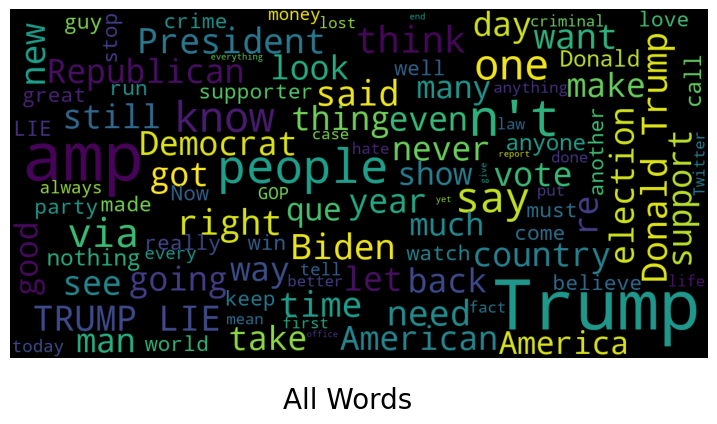

In [23]:
all_words = df[df['sentiment'] > -1]['processed_text']
show_wordcloud(all_words, title = 'All Words')

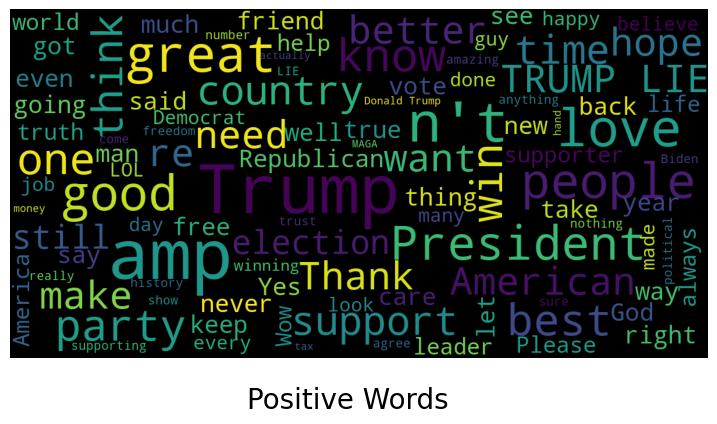

In [24]:
positive_words = df[df['sentiment'] > 0.8]['processed_text']
show_wordcloud(positive_words, title = 'Positive Words')

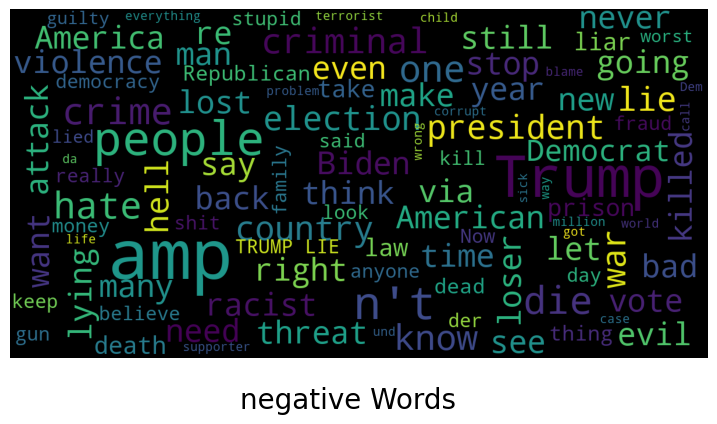

In [25]:
negative_words = df[df['sentiment'] < -0.8]['processed_text']
show_wordcloud(negative_words, title = 'negative Words')

Top 5 most positive and most negative tweets

In [26]:
most_negative = df.sort_values(by=['sentiment'], ascending=True).head(5)
most_negative

,id,date,username,content,url,processed_text,sentiment,emotions,tweet_date
35437,1656445714518642688,2023-05-10 23:46:48+00:00,sethrow991,Liars cheaters mass murderers racist entitled ...,https://twitter.com/sethrow991/status/16564457...,"[Liars, cheater, mass, murderer, racist, entit...",-0.9924,Fear,2023-05-10 00:00:00+00:00
23893,1614771498597638150,2023-01-15 23:48:20+00:00,brok3n_r3cord,"Fuck #Republicans, fuck #Democrats, fuck #Trum...",https://twitter.com/brok3n_r3cord/status/16147...,"[Fuck, fuck, fuck, amp, fuck, fuck, stupid, fu...",-0.9890,Happy,2023-01-15 00:00:00+00:00
36204,1659342998583275520,2023-05-18 23:39:34+00:00,AshleyWeis4,🚨🗣️📣 #BREAKING: 𝘛𝘙𝘌𝘈𝘚𝘖𝘕𝘖𝘜𝘚 𝘛𝘜𝘙𝘕𝘊𝘖𝘈𝘛: John Bren...,https://twitter.com/AshleyWeis4/status/1659342...,"[🚨🗣️📣, 𝘛𝘙𝘌𝘈𝘚𝘖𝘕𝘖𝘜𝘚, 𝘛𝘜𝘙𝘕𝘊𝘖𝘈𝘛, John, Brennan, En...",-0.9880,Fear,2023-05-18 00:00:00+00:00
24177,1615861468133560320,2023-01-18 23:59:29+00:00,anauburntiger,It's literally comical at this pt... everythin...,https://twitter.com/anauburntiger/status/16158...,"[literally, comical, ..., everything, falsely,...",-0.9853,Sad,2023-01-18 00:00:00+00:00
29329,1634333917904879616,2023-03-10 23:22:25+00:00,CanadaFellow,"Countless affairs, rape, 25+ sexual assaults, ...",https://twitter.com/CanadaFellow/status/163433...,"[Countless, affair, rape, 25+, sexual, assault...",-0.9837,Surprise,2023-03-10 00:00:00+00:00


In [27]:
most_positive = df.sort_values(by=['sentiment'], ascending=False).head(5)
most_positive

,id,date,username,content,url,processed_text,sentiment,emotions,tweet_date
34547,1653177811023134722,2023-05-01 23:21:19+00:00,whoopibella,Look at what I got! \n\n#trump\n#letters2trump...,https://twitter.com/whoopibella/status/1653177...,"[Look, got, Hmmm, love, feel, like, super, hig...",0.9849,Happy,2023-05-01 00:00:00+00:00
34468,1653187411713859584,2023-05-01 23:59:28+00:00,BalochJamshaid,@TheMAGAMovement @Entium8 @SheriHerman19 @Musk...,https://twitter.com/BalochJamshaid/status/1653...,"[Awesome, title, Peace, Awesome, President, Aw...",0.9823,Surprise,2023-05-01 00:00:00+00:00
36086,1658983354534903808,2023-05-17 23:50:28+00:00,Boykin4NcLtGov,"LIFE, LIBERTY, JUSTICE FOR ALL\nPROTECT OUR CO...",https://twitter.com/Boykin4NcLtGov/status/1658...,"[LIFE, LIBERTY, JUSTICE, FOR, ALL, PROTECT, OU...",0.9747,Fear,2023-05-17 00:00:00+00:00
8890,1559687660003885058,2022-08-16 23:44:50+00:00,ccoutis,Thanks Liz for putting Country over Party. I m...,https://twitter.com/ccoutis/status/15596876600...,"[Thanks, Liz, putting, Country, Party, may, ag...",0.9729,Happy,2022-08-16 00:00:00+00:00
18613,1595563339127586820,2022-11-23 23:41:58+00:00,CDV4Democracy,@GriecoVin @Stonekettle No. We are NOT. \nThis...,https://twitter.com/CDV4Democracy/status/15955...,"[NOT, This, asked, THIS, great, American, dad,...",0.9705,Happy,2022-11-23 00:00:00+00:00


Charts for the most popular emotions, the most popular sentiments and the sentiment line chart over time (full year).

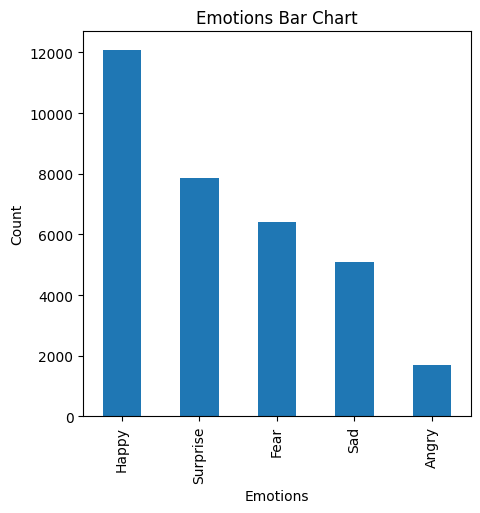

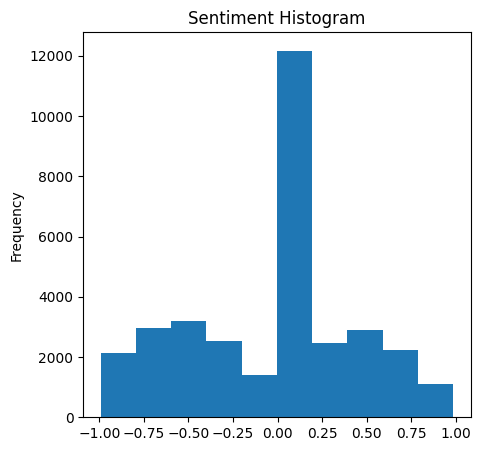

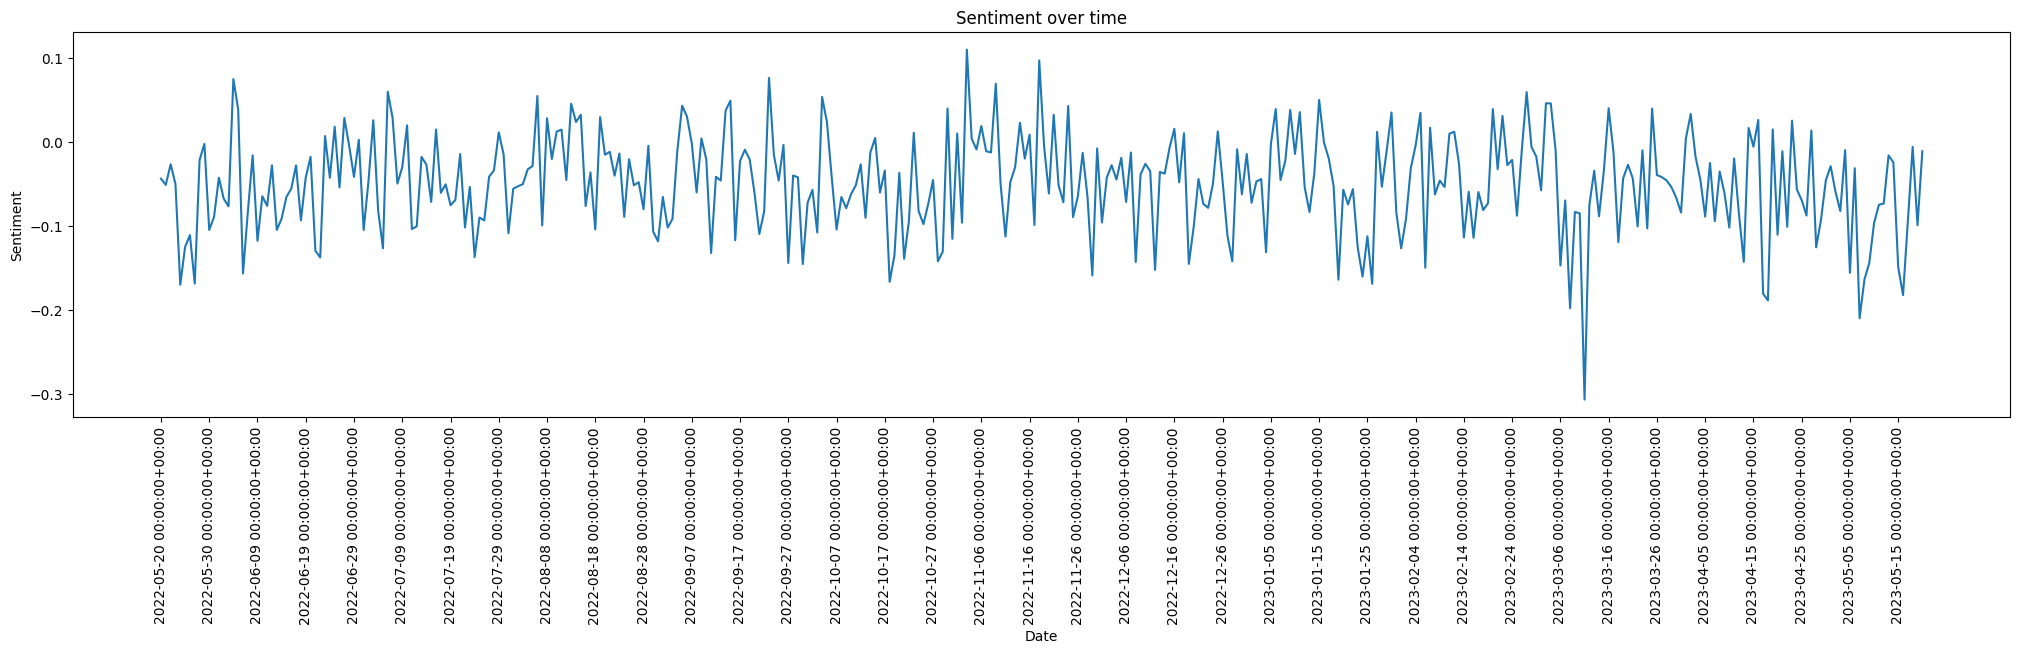

In [28]:
df.to_csv('trump_tweets.csv', index=False)
df = pd.read_csv('trump_tweets.csv')
df['processed_text'] = df['processed_text'].apply(lambda x: eval(x))

plt.figure(figsize=(5, 5))
emotions_count = df['emotions'].value_counts()
emotions_count.plot(kind='bar')
plt.title('Emotions Bar Chart')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(5,5))
df['sentiment'].plot(kind='hist')
plt.title('Sentiment Histogram')
plt.show()

sentiment_df_by_day = df.groupby('tweet_date')['sentiment'].mean().reset_index()
plt.figure(figsize=(25, 5))
plt.title('Sentiment over time')
plt.plot(sentiment_df_by_day['tweet_date'], sentiment_df_by_day['sentiment'])
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.xticks(sentiment_df_by_day['tweet_date'][::10], rotation=90)
plt.show()

Statistic data for sentiment and emotions

In [29]:
sentiment_results = df['sentiment'].apply(pd.Series)
sentiment_results.describe()

,0
count,33115.000000
mean,-0.049610
std,0.454395
min,-0.992400
25%,-0.401900
50%,0.000000
75%,0.233100
max,0.984900


In [30]:
emotion_results = df['emotions'].apply(pd.Series)
emotion_results.describe()

,0
count,33115
unique,5
top,Happy
freq,12089


# Summary

Overall, tweets with the hashtag #trump have divided opinions (as is the case in politics, especially since there are 2 parties in the US). However, there is more fear, sadness or anger than happiness, so you can say that negative tweets have a slight advantage. Everything will be revealed in the 2024 elections.

# Bibliography and links
- https://twitter.com/
- https://www.nltk.org/
- https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
- https://pypi.org/project/text2emotion/
- https://pypi.org/project/snscrape/
- https://pypi.org/project/wordcloud/
- https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/
- https://www.kaggle.com/general/202461